In [1]:
import sys
sys.path.append("scripts/")
import numpy as np
from gridmap import*
from robot import*
from scipy.stats import expon, norm, uniform

In [2]:
def occupancyToColor(occupancy):
    return "#"+format(int(255*(1-occupancy)), '02x')*3

class IdealSensor():
    def __init__(self, world, sensing_range=3, obstacle_expand=0):
        self.world = world
        self.sensing_range = []
        for i in range(-sensing_range, sensing_range):
            for j in range(-sensing_range, sensing_range):
                if np.sqrt(i**2 + j**2) > sensing_range or (i==0 and j==0):
                    continue
                self.sensing_range.append(np.array([i, j]))
        #ob_range = list(range(-obstacle_expand, obstacle_expand+1))
        #self.obstacles_expands = np.array(np.meshgrid(ob_range, ob_range)).T.reshape(-1, 2)
        #self.obstacles_expands = np.delete(self.obstacles_expands, np.argmax(np.all([0, 0] == self.obstacles_expands, axis=1)), axis=0)
    
    def sense(self, index):
        obstacle_grids = [[index, 0]]
        for sensing_grid in self.sensing_range:
            u = index + sensing_grid
            if self.world.isOutOfBounds(u):
                continue
            elif self.world.grid_map_real[u[0]][u[1]] == '0':
                obstacle_grids.append([u, 1])
                #for obs_expand in self.obstacles_expands:
                #    exp_grid = u + obs_expand
                #    if not self.world.isOutOfBounds(exp_grid):
                #        if not np.any(np.all(exp_grid == [obs_grid[0] for obs_grid in obstacle_grids], axis=1)):
                #            obstacle_grids.append([exp_grid, 1])
                #        else:
                #            idx = np.argmax(np.all(exp_grid == [obs_grid[0] for obs_grid in obstacle_grids], axis=1))
                #            obstacle_grids.pop(idx)
                #            obstacle_grids.append([exp_grid, 1])
            else:
                #if not np.any(np.all(u == [obs_grid[0] for obs_grid in obstacle_grids], axis=1)):
                obstacle_grids.append([u, 0])
        return obstacle_grids
    
    def plot(self, figsize=(4, 4), robot_index=np.array([10, 10]), obstacle_expands=False, save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map_real):
            if grid == '0':
                self.world.drawGrid(index, "lightgray", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal
                self.world.drawGrid(index, "green", 1.0, ax)
        
        self.world.drawGrid(robot_index, "red", 1.0, ax)
        for index, occupancy in self.sense(robot_index):
            if occupancy < 0.3:
                continue
            if not self.world.isStart(index) and not self.world.isGoal(index):
                if obstacle_expands is True and self.world.grid_map_real[index[0]][index[1]] == '1':
                    self.world.drawGrid(index, "dimgray", 1.0, ax)
                else:
                    self.world.drawGrid(index, occupancyToColor(occupancy), 1.0, ax)
        
        plt.show()
        
        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

In [3]:
def lToP(l):
    return 1 - 1/(1+ np.exp(l))

def pToL(p):
    return np.log(p/(1-p))

def updateL(l, p):
    return l + np.log(p/(1-p))

def updateP(p, p_):
    l = pToL(p)
    l = updateL(l, p_)
    return lToP(l)

class Sensor(IdealSensor):
    def __init__(self, world, sensing_range=3):
        self.world = world
        self.sensing_range = sensing_range
        self.sensing_grids = []
        for i in range(-sensing_range, sensing_range):
            for j in range(-sensing_range-1, sensing_range+1):
                if np.sqrt(i**2 + j**2) > sensing_range or (i==0 and j==0):
                    continue
                self.sensing_grids.append(np.array([i, j]))
        
    def sense(self, index):
        obstacle_grids = []
        for sensing_grid in self.sensing_grids:
            u = index + sensing_grid
            if self.world.isOutOfBounds(u) or np.all(index == u):
                continue
            if self.world.isObstacle(u):
                if len(obstacle_grids) > 0 and np.any(np.all(u==[obstacle[0] for obstacle in obstacle_grids], axis=1)):
                    id = np.argmax(np.all(u == [obstacle[0] for obstacle in obstacle_grids], axis=1))
                    grid, occupancy = obstacle_grids[id]
                    l = pToL(occupancy)
                    l = updateL(l, 0.7)
                    obstacle_grids[id][1] = lToP(l)
                else:
                    obstacle_grids.append([u, 0.7])
                    
                for neigbor_grid in neigbor_grids:
                    u_neigbor = u + neigbor_grid
                    if np.sqrt(neigbor_grid[0]**2 + neigbor_grid[1]**2) > self.sensing_range or np.all(index==u_neigbor):
                        continue
                    if self.world.isOutOfBounds(u_neigbor):
                        continue
                    if self.world.isObstacle(u_neigbor):
                        p = 0.7
                    elif np.all(np.abs(neigbor_grid) == [1, 1]):
                        p = 0.1
                    else:
                        p = 0.3
                    if np.any(np.all(u_neigbor==[obstacle[0] for obstacle in obstacle_grids], axis=1)):
                        id = np.argmax(np.all(u_neigbor == [obstacle[0] for obstacle in obstacle_grids], axis=1))
                        grid, occupancy = obstacle_grids[id]
                        if p < 0.5:
                            obstacle_grids[id][1] += 0.5 * (1-np.exp(-p))
                        else:
                            l = pToL(occupancy)
                            l = updateL(l, p)
                            obstacle_grids[id][1] = lToP(l)
                    else:
                        obstacle_grids.append([u_neigbor, p])
        return obstacle_grids

<IPython.core.display.Javascript object>


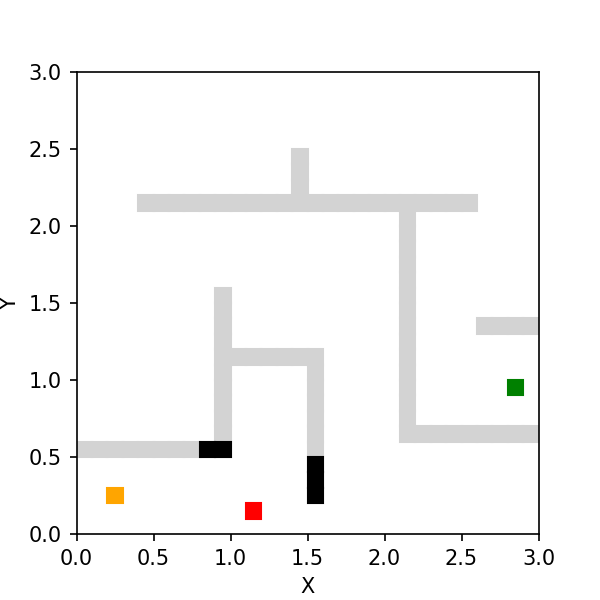

In [4]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1

    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])

    map_data = "./csvmap/map2.csv"

    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", obstacle_expand=1, debug=False)
    sensor = IdealSensor(world, sensing_range=5, obstacle_expand=1)
    sensor.plot(figsize=(4, 4), robot_index=np.array([11, 1]), obstacle_expands=True)